# (Non)-robustness of linear regression

In [1]:
library(tidyverse)
library(gridExtra)
library(pracma)


theme_update(text = element_text(size=24))
options(repr.plot.width=12, repr.plot.height=6)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr

# Bodyfat

In [2]:
bodyfat_df <- read.csv("../datasets/bodyfat.csv")
head(bodyfat_df)
nrow(bodyfat_df)

252

In [3]:
vars <- c("Weight", "Height", "Abdomen")
stopifnot(all(vars %in% names(bodyfat_df)))

regressors <- paste(vars, collapse=" + ")
reg_form <- formula(paste0("bodyfat ~ 1 + ", regressors))

test_rows <- sample(1:nrow(bodyfat_df), 30)
train_df <- bodyfat_df[-test_rows, ]
test_df <- bodyfat_df[test_rows, ]

In [4]:
reg_form

bodyfat ~ 1 + Weight + Height + Abdomen


Call:
lm(formula = reg_form, data = train_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.5383  -3.1547   0.0127   3.0821  10.1382 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -37.61213    7.26865  -5.175 5.17e-07 ***
Weight       -0.13721    0.02508  -5.470 1.23e-07 ***
Height       -0.09763    0.09004  -1.084    0.279    
Abdomen       0.95363    0.06609  14.429  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.403 on 218 degrees of freedom
Multiple R-squared:  0.7064,    Adjusted R-squared:  0.7024 
F-statistic: 174.9 on 3 and 218 DF,  p-value: < 2.2e-16

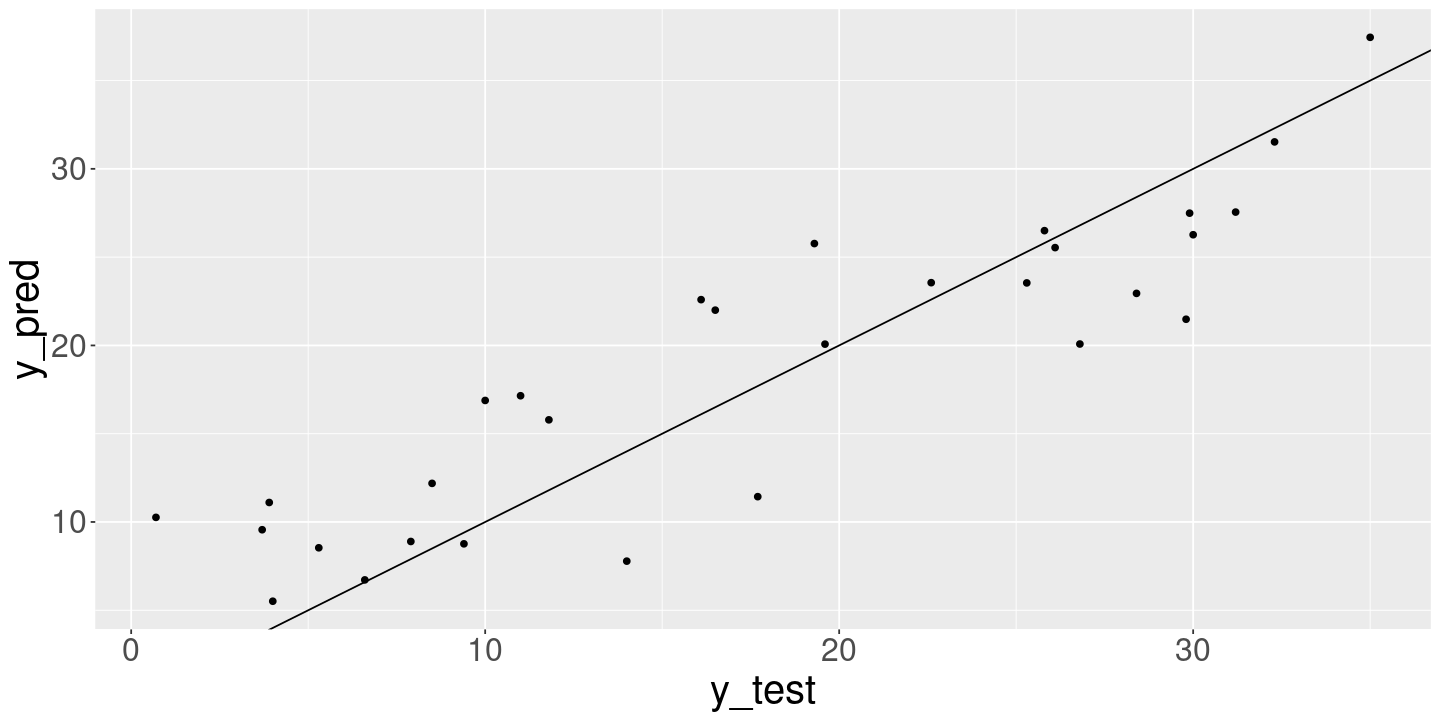

In [5]:
reg <- lm(reg_form, train_df)
summary(reg)
y_pred <- predict(reg, test_df)
y_test <- test_df$bodyfat
ggplot() +
    geom_point(aes(x=y_test, y=y_pred)) +
    geom_abline(aes(slope=1, intercept=0))


In [6]:
RunChangedRegressions <- function(ChangeFun, change_prop) {
    pred_df <- data.frame()
    fit_df <- data.frame()
    coef_names <- names(coef(reg))
    for (prop in change_prop) {
        change_df <- ChangeFun(prop)
        reg_change <- lm(reg_form, change_df)
        y_pred <- predict(reg_change, test_df)
        this_pred_df <- data.frame(prop=prop, y_pred=y_pred, y=y_test) %>% mutate(ind=1:n())
        pred_df <- bind_rows(pred_df, this_pred_df)         
        beta_df <- data.frame(prop, betahat=coef(reg_change), betahat_orig=coef(reg))
        beta_df$coef <- coef_names
        rownames(beta_df) <- NULL
        fit_df <- bind_rows(fit_df, beta_df)
    }

    return(list(fit_df=fit_df, pred_df=pred_df))
}

# Try changing a y value

In [7]:
change_row <- 1
y0 <- train_df[change_row, "bodyfat"]
y_sd <- sd(train_df$bodyfat)


ChangeY <- function(prop) {
    change_df <- train_df
    change_df[change_row, "bodyfat"] <- y0 + y_sd * prop
    return(change_df)
}

change_prop <- seq(1, 1e6, length.out=10)


y_experiment <- RunChangedRegressions(ChangeY, change_prop)

In [8]:
change_prop

1 111112 222223 333334 444445 555556 666667 777778 888889 1e+06

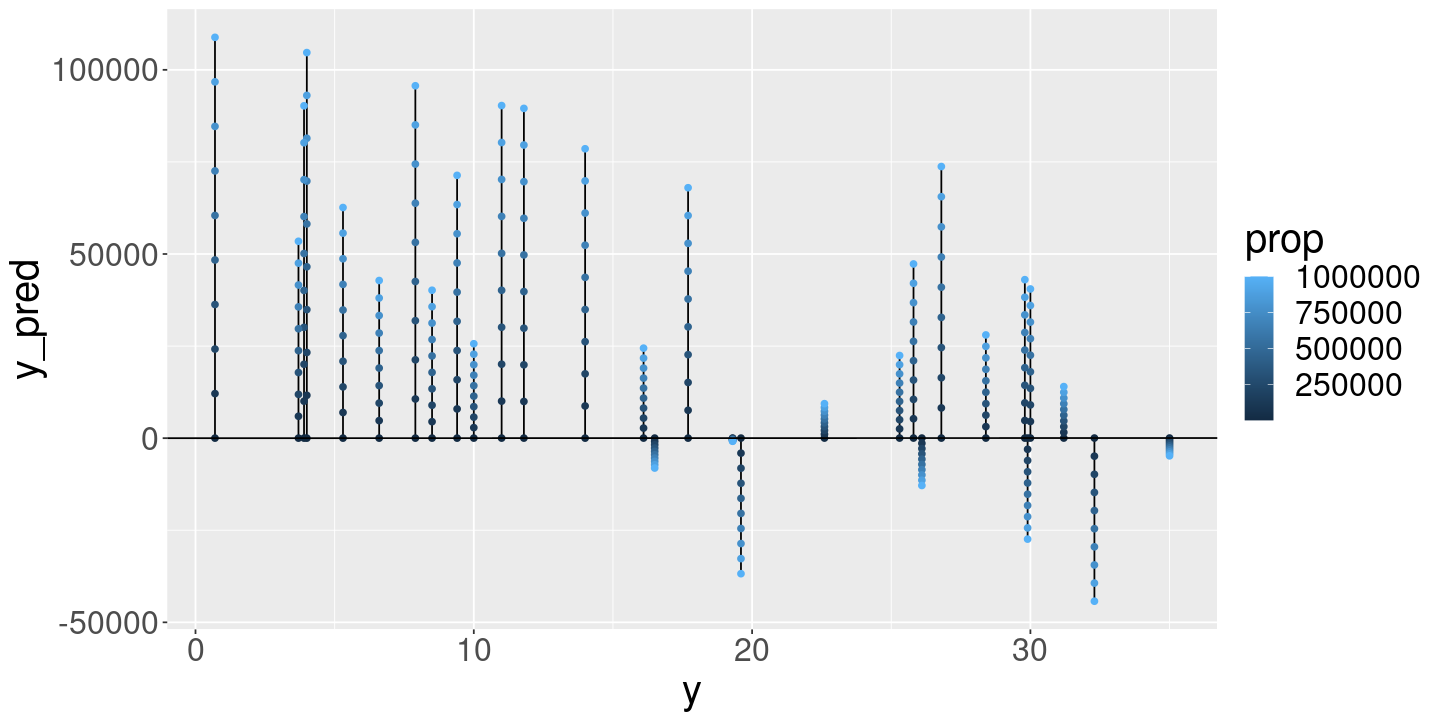

In [9]:
ggplot(y_experiment$pred_df) +
    geom_line(aes(x=y, y=y_pred, group=ind))  +
    geom_point(aes(x=y, y=y_pred, color=prop, group=ind))  +
    geom_abline(aes(slope=1, intercept=0))


Call:
lm(formula = reg_form, data = change_df)

Coefficients:
(Intercept)       Weight       Height      Abdomen  
  546635374      -755549     -4525476      -618550  


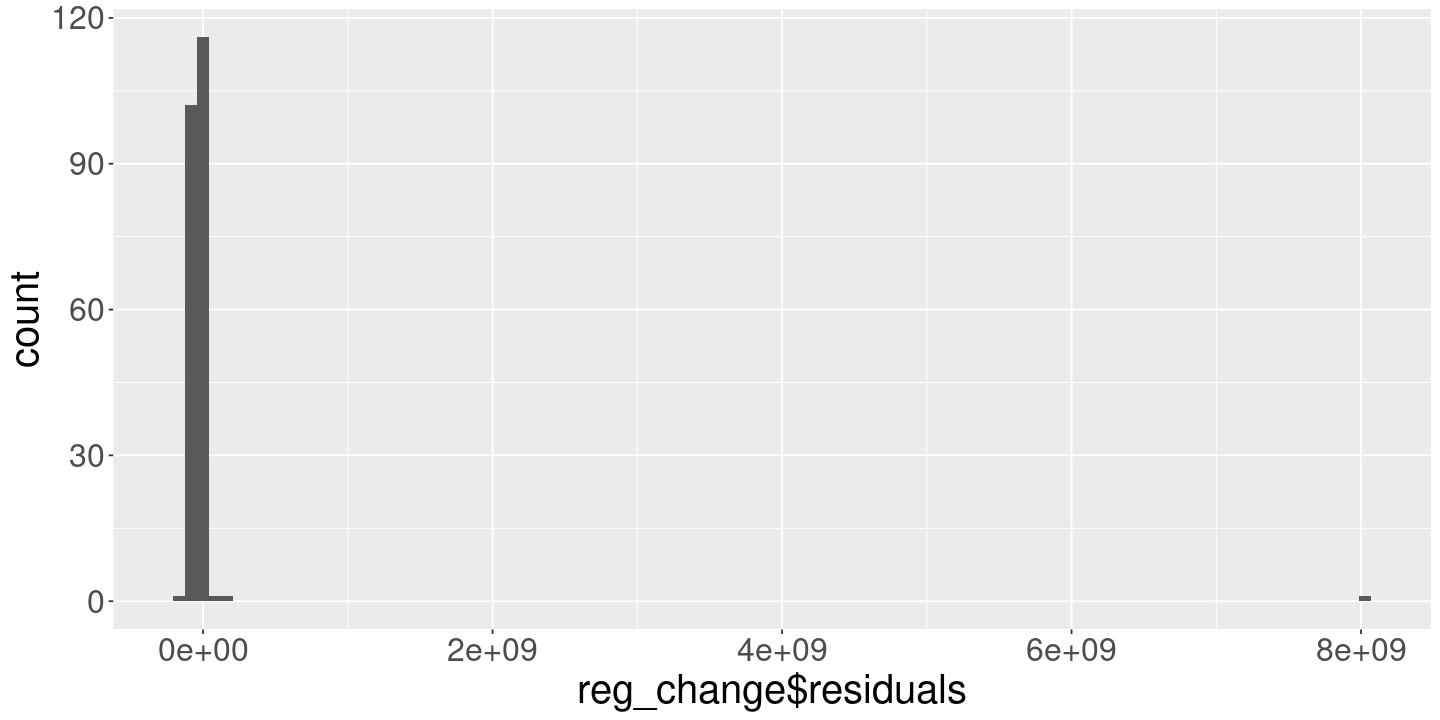

In [10]:
change_df <- ChangeY(1e9)
reg_change <- lm(reg_form, change_df)
print(reg_change)
ggplot() +
    geom_histogram(aes(x=reg_change$residuals), bins=100)

In [11]:
which.max(abs(reg_change$residuals))
print(change_row)

1: 1

[1] 1

# Try changing an x value

In [12]:
change_row <- 1
change_var <- vars[1]
print(change_var)
res0 <- summary(reg)$residuals[change_row]
y0 <- train_df[change_row, "bodyfat"]
x0 <- train_df[change_row, change_var]
x_sd <- sd(train_df[, change_var])


ChangeX <- function(prop) {
    change_df <- train_df
    change_df[change_row, change_var] <- x0 + x_sd * prop
    return(change_df)
}

[1] "Weight"

In [13]:
change_prop <- seq(1, 1000000, length.out=100)
x_experiment <- RunChangedRegressions(ChangeX, change_prop)

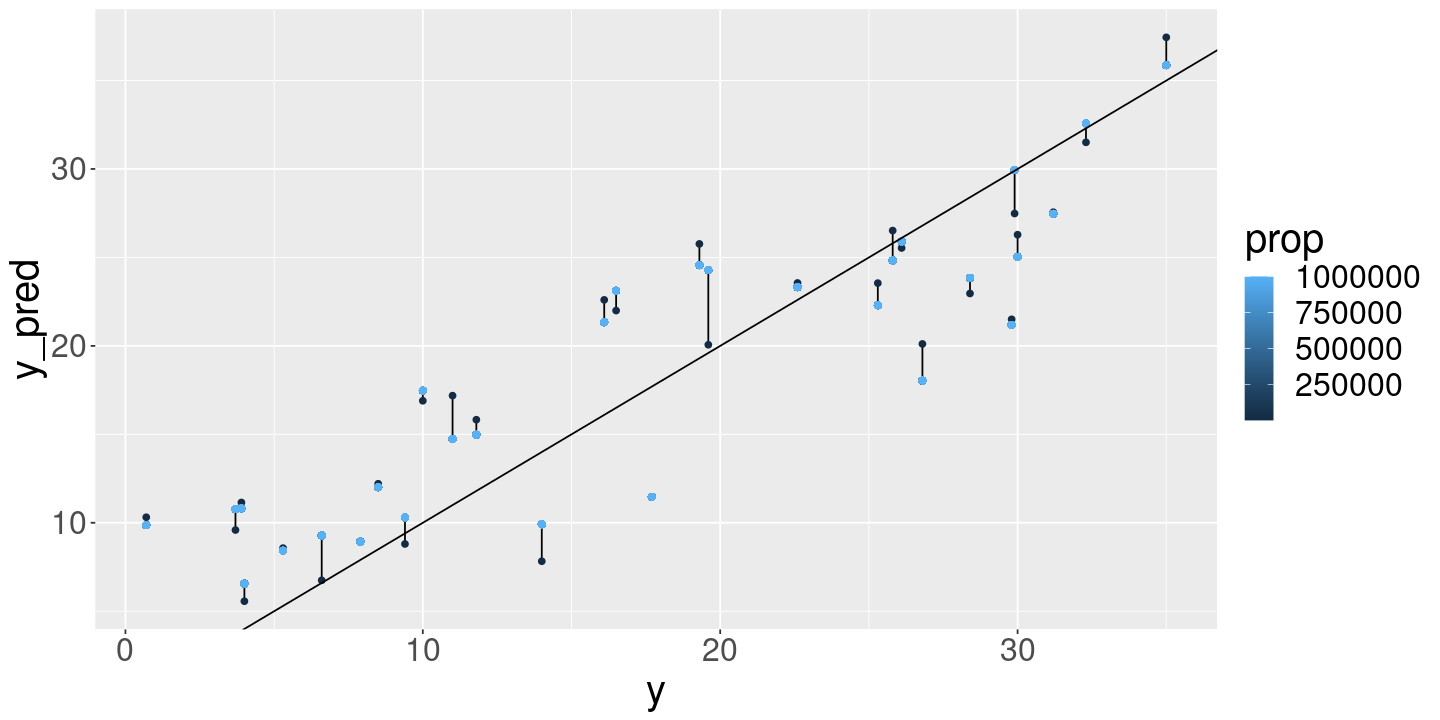

In [14]:
ggplot(x_experiment$pred_df) +
    geom_line(aes(x=y, y=y_pred, group=ind))  +
    geom_point(aes(x=y, y=y_pred, color=prop, group=ind))  +
    geom_abline(aes(slope=1, intercept=0))

In [15]:
change_df <- ChangeX(1e9)
reg_change <- lm(reg_form, change_df)
print(reg_change)

# I believe this doesn't match due to numerical error
y0_pred <- predict(reg_change, train_df[change_row, ])
print(y0_pred)
print(train_df[change_row, "bodyfat"])


Call:
lm(formula = reg_form, data = change_df)

Coefficients:
(Intercept)       Weight       Height      Abdomen  
 -1.486e+01   -1.119e-10   -3.399e-01    6.265e-01  

       1 
15.48924 
[1] 12.3

[1] "Weight"

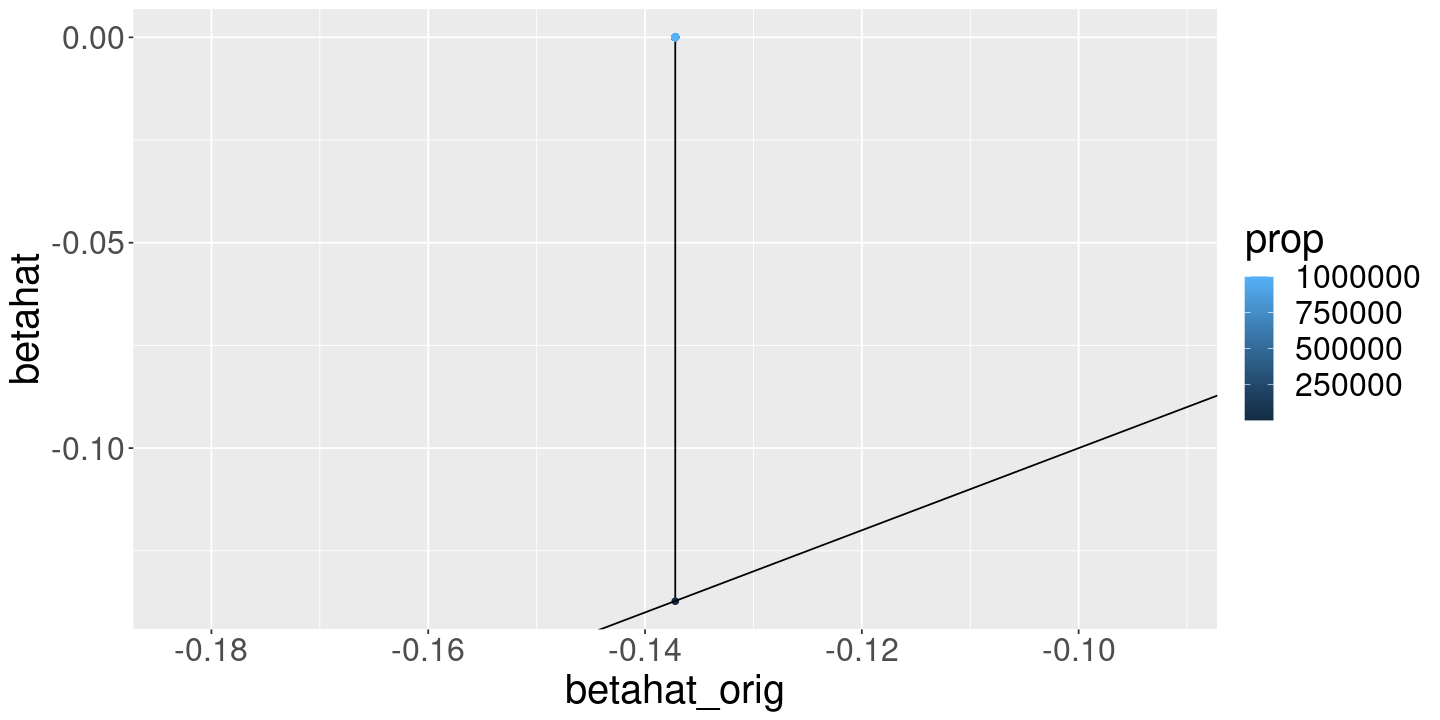

In [16]:
print(change_var)
x_experiment$fit_df %>% filter(coef==change_var) %>%
    ggplot(aes(x=betahat_orig, y=betahat)) +
        geom_line(aes(group=coef))  +
        geom_point(aes(color=prop))  +
        geom_abline(aes(slope=1, intercept=0))

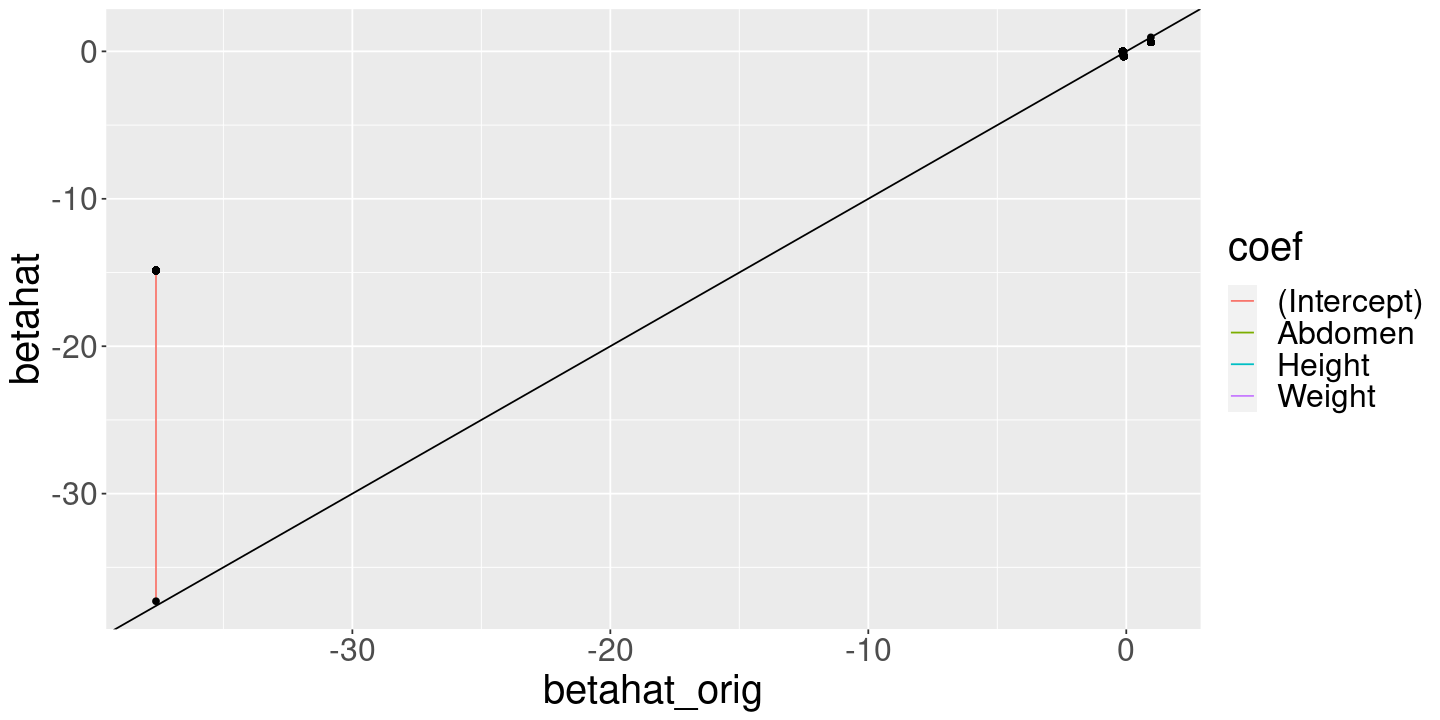

In [17]:
x_experiment$fit_df %>% filter() %>%
    ggplot(aes(x=betahat_orig, y=betahat)) +
        geom_line(aes(group=coef, color=coef))  +
        geom_point(aes())  +
        geom_abline(aes(slope=1, intercept=0))

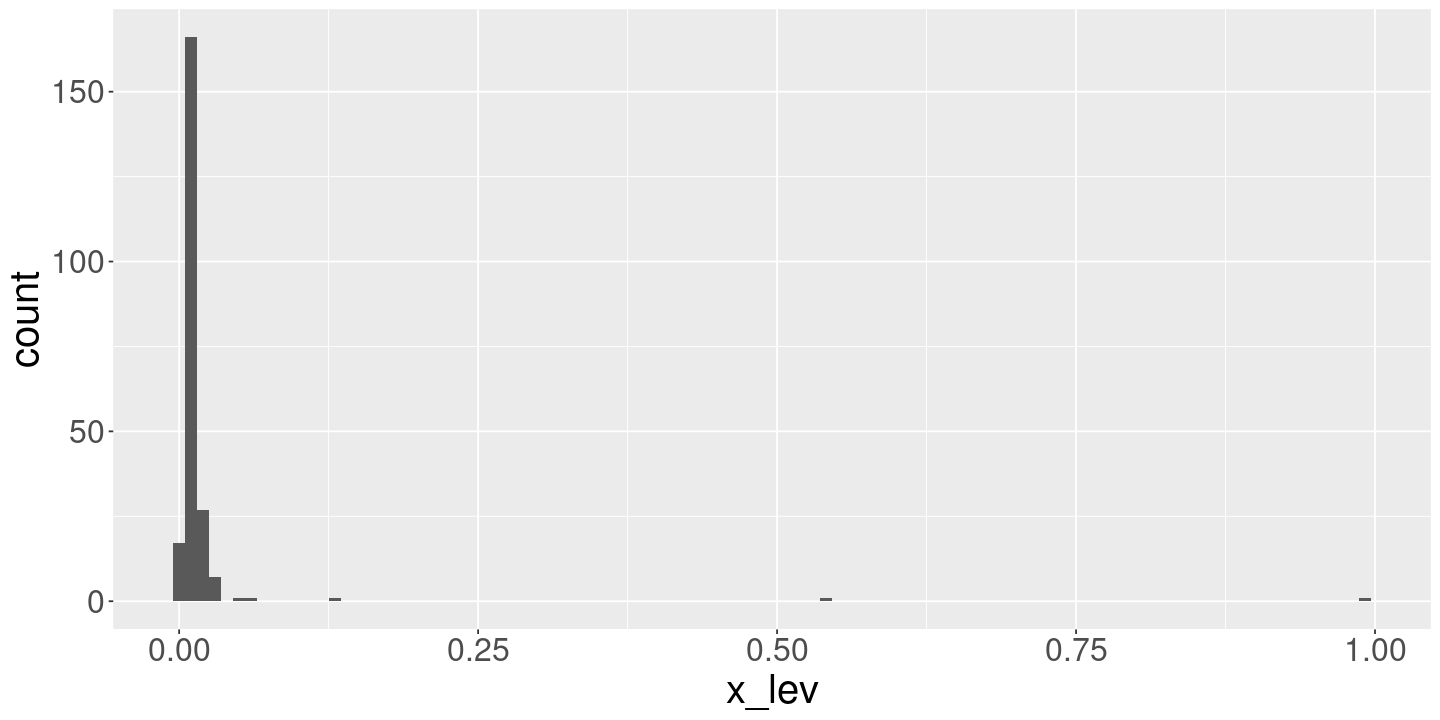

In [18]:
change_df <- ChangeX(100)
x_change <- model.matrix(reg_form, change_df)
x_proj <- x_change %*% pinv(t(x_change) %*% x_change) %*% t(x_change)
x_lev <- diag(x_proj)
ggplot() + geom_histogram(aes(x=x_lev), bins=100)

In [19]:
change_df[which.max(x_lev), ]